## Task 3 - Predicting Cancellation Risk (Classification)

In Task 2 we showed that extreme delays are rare, hard to predict, and
dominate the model errors. This naturally leads to a more operational
question:

> **Can we directly predict whether a train will be cancelled?**

Instead of estimating delay magnitude, Task 3 reframes the problem as a  
**binary / probabilistic risk classification** task.

Previous exploratory results already indicate that cancellation risk is
systematic and varies with environmental and operational conditions.


## Hypotheses

We formulate a binary classification task to predict whether a train run will be cancelled.
Cancellations are rare events (≈5% of all observations), which makes this a highly imbalanced
learning problem.

**H5:** Operational, temporal, and environmental features contain predictive signal for cancellations.  
**H6:** Non-linear models outperform linear baselines in detecting rare cancellation events.


## Modeling Strategy

We begin with interpretable linear models and then move to non-linear classifiers:

- **Logistic Regression**  
  Linear baseline, probabilistic output, transparent coefficients.

- **Random Forest**  
  Captures non-linear interactions, robust to outliers, handles mixed feature types.

To address class imbalance, the minority class is upsampled during training.

The objective is not only classification accuracy, but **risk detection**:
Which situations are most likely to end in cancellation?

This reframes the task from prediction to **operational decision support**.


In [27]:
!pip install -r requirements.txt

In [28]:

import pandas as pd, json

train_sub = pd.read_parquet("data/processed/train_sub_task2.parquet")
test = pd.read_parquet("data/processed/test_task2.parquet")

with open("data/processed/features_task2.json", "r") as f:
    features = json.load(f)

print("Train:", train_sub.shape)
print("Test :", test.shape)
print("Features:", len(features))




Train: (200000, 52)
Test : (1956978, 53)
Features: 23


In [29]:

import os
os.path.exists("data/processed"), os.listdir("data/processed")[:30]


(True,
 ['daily_station_weather.parquet',
  'df_panel.parquet',
  'features.json',
  'features_task2.json',
  'station_geo.parquet',
  'test_dec_base.parquet',
  'test_task2.parquet',
  'train_sub_base.parquet',
  'train_sub_task2.parquet'])

In [30]:
train_sub.columns


Index(['station_name', 'xml_station_name', 'eva', 'train_name',
       'final_destination_station', 'delay_in_min', 'time', 'is_canceled',
       'train_type', 'train_line_ride_id', 'train_line_station_num',
       'arrival_planned_time', 'arrival_change_time', 'departure_planned_time',
       'departure_change_time', 'id', 'month', 'season', 'delay_in_min_clean',
       'date', 'hour', 'dow', 'is_weekend', 'is_holiday', 'is_workday',
       'is_peak', 'is_night', 'tavg', 'prcp', 'snow', 'lat', 'lon',
       'delay_pos', 'dwell_slack', 'actual_dwell', 'arr_planned_dt',
       'dep_planned_dt', 'next_arr_planned_dt', 'travel_time', 'next_lat',
       'next_lon', 'distance_to_next', 'current_delay', 'next_delay',
       'delta_delay', 'delta_delay_clip', 'station_cancel_rate',
       'station_mean_delay', 'station_p90_delay', 'station_volume',
       'station_risk_score', 'is_summer'],
      dtype='object')

In [31]:


# 1) unify target column name 
# dataset column is 'is_canceled' (one 'l')
train_sub["is_canceled"] = train_sub["is_canceled"].astype(int)
test["is_canceled"] = test["is_canceled"].astype(int)

# 2) build station stats from TRAIN only (avoid leakage)
station_stats = (
    train_sub.groupby("eva")
    .agg(
        station_volume=("eva", "size"),
        station_cancel_rate=("is_canceled", "mean"),
    )
    .reset_index()
)
station_stats["station_risk_score"] = 100 * station_stats["station_cancel_rate"]

# 3) merge into train/test
cols_add = ["eva", "station_volume", "station_cancel_rate", "station_risk_score"]
train_sub = train_sub.merge(station_stats[cols_add], on="eva", how="left", suffixes=("", "_stat"))
test = test.merge(station_stats[cols_add], on="eva", how="left", suffixes=("", "_stat"))

# 4) verify D
need = ["station_volume", "station_cancel_rate", "station_risk_score"]
print("Missing after merge:", [c for c in need if c not in train_sub.columns])
print(train_sub[need].head())



Missing after merge: []
   station_volume  station_cancel_rate  station_risk_score
0           52203             0.054595            4.400801
1          112599             0.054210            8.736054
2          247384             0.069968            3.849339
3           78811             0.018716            3.134347
4           45654             0.037083            4.661037


In [32]:
train_sub["is_cancelled"] = train_sub["is_canceled"].astype(int)
test["is_cancelled"]      = test["is_canceled"].astype(int)

X_train = train_sub[features]
y_train = train_sub["is_cancelled"].astype(int)

X_test  = test[features]
y_test  = test["is_cancelled"].astype(int)

print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())


(200000, 23) (1956978, 23) 0.049685 0.04548697021632333


In [33]:
print("Overall cancellation rate:", y_train.mean())



Overall cancellation rate: 0.049685


KeyboardInterrupt: 

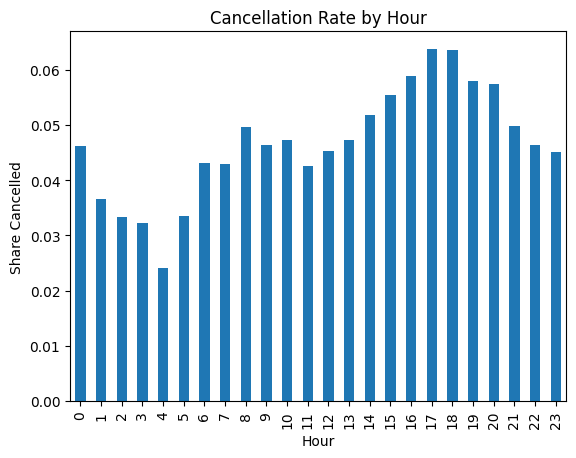

In [34]:
import matplotlib.pyplot as plt

cancel_by_hour = train_sub.groupby("hour")["is_cancelled"].mean()

cancel_by_hour.plot(kind="bar")
plt.title("Cancellation Rate by Hour")
plt.ylabel("Share Cancelled")
plt.xlabel("Hour")
plt.tight_layout()
plt.show()



In [ ]:
train_sub.groupby("is_night")["is_cancelled"].mean()




is_night
0    0.051198
1    0.035448
Name: is_cancelled, dtype: float64

In [ ]:
train_sub.groupby("is_weekend")["is_cancelled"].mean()

is_weekend
0    0.052335
1    0.041943
Name: is_cancelled, dtype: float64

In [ ]:
train_sub.groupby(pd.cut(train_sub["tavg"], bins=6))["is_cancelled"].mean()
train_sub.groupby(pd.cut(train_sub["prcp"], bins=[0,0.1,2,10,100]))["is_cancelled"].mean()


C:\Users\Joni7\AppData\Local\Temp\ipykernel_559220\2040733513.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_sub.groupby(pd.cut(train_sub["tavg"], bins=6))["is_cancelled"].mean()
C:\Users\Joni7\AppData\Local\Temp\ipykernel_559220\2040733513.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_sub.groupby(pd.cut(train_sub["prcp"], bins=[0,0.1,2,10,100]))["is_cancelled"].mean()


prcp
(0.0, 0.1]       0.048096
(0.1, 2.0]       0.048048
(2.0, 10.0]      0.046771
(10.0, 100.0]    0.045103
Name: is_cancelled, dtype: float64

In [ ]:
x = train_sub["train_line_station_num"].rank(method="first")
train_sub.groupby(pd.qcut(x, 5))["is_cancelled"].mean()



C:\Users\Joni7\AppData\Local\Temp\ipykernel_559220\1516398060.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_sub.groupby(pd.qcut(x, 5))["is_cancelled"].mean()


train_line_station_num
(0.999, 40000.8]        0.040500
(40000.8, 80000.6]      0.053075
(80000.6, 120000.4]     0.052500
(120000.4, 160000.2]    0.047925
(160000.2, 200000.0]    0.054425
Name: is_cancelled, dtype: float64

In [ ]:
x = train_sub["dwell_slack"].rank(method="first")
train_sub.groupby(pd.qcut(x, 5))["is_cancelled"].mean()



C:\Users\Joni7\AppData\Local\Temp\ipykernel_490080\2325405372.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_sub.groupby(pd.qcut(x, 5))["is_cancelled"].mean()


dwell_slack
(0.999, 22074.2]       0.059889
(22074.2, 44147.4]     0.057899
(44147.4, 66220.6]     0.058442
(66220.6, 88293.8]     0.050786
(88293.8, 110367.0]    0.049470
Name: is_cancelled, dtype: float64

Data Preprocessing for Cancellation Prediction

The target variable cancellation is highly imbalanced.
Only about 5 % of all train rides are cancelled, while 95 % operate normally.

This causes a strong bias in standard classification models:
a naive model that always predicts “not cancelled” would already reach 95 % accuracy, but would fail to identify any real cancellations.

Therefore, we apply special preprocessing techniques for imbalanced data.
To avoid data leakage, all resampling methods are applied only on the training data.
As a first countermeasure, we use class weighting in logistic regression.

In [ ]:
X_train.isna().sum().sort_values(ascending=False).head(10)


travel_time            168849
dwell_slack             89633
actual_dwell            89614
distance_to_next        29943
tavg                    21743
lat                     13933
lon                     13933
station_p90_delay           0
station_cancel_rate         0
snow                        0
dtype: int64

Before training the logistic regression, all non-numeric features were removed and missing values were imputed using the median. Infinite values were replaced with NaN. This ensures a valid numerical feature matrix for the classifier.

In [ ]:
import numpy as np

X = train_sub.drop(columns=["is_cancelled"])
y = train_sub["is_cancelled"]

X = X.replace([np.inf, -np.inf], np.nan)
X = X.select_dtypes(include="number")
X = X.fillna(X.median())


In [ ]:
leak_cols = [c for c in train_sub.columns if "cancel" in c.lower()]
print("Leak columns:", leak_cols)

X = train_sub.drop(columns=leak_cols + ["is_cancelled", "is_canceled"], errors="ignore")
X = X.select_dtypes(include="number")
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

y = train_sub["is_cancelled"]


Leak columns: ['is_canceled', 'station_cancel_rate', 'station_cancel_rate_stat', 'is_cancelled']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
print("Index overlap:", len(set(X_train.index) & set(X_val.index)))
print("y_val unique:", np.unique(y_val, return_counts=True))


Index overlap: 0
y_val unique: (array([0, 1]), array([38013,  1987]))


In [ ]:
from sklearn.linear_model import LogisticRegression

model_w = LogisticRegression(class_weight="balanced", max_iter=1000)
model_w.fit(X_train, y_train)


c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [ ]:
from sklearn.metrics import classification_report, average_precision_score

y_proba = model_w.predict_proba(X_val)[:,1]
print("PR-AUC:", average_precision_score(y_val, y_proba))

PR-AUC: 0.09327205363437302


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [ ]:
model_sm = LogisticRegression(max_iter=1000)
model_sm.fit(X_train_sm, y_train_sm)


c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [ ]:
from sklearn.metrics import classification_report, average_precision_score

y_proba = model_sm.predict_proba(X_val)[:,1]
print("PR-AUC:", average_precision_score(y_val, y_proba))


PR-AUC: 0.09434376316687665



Using class-weighted logistic as well as Systematic Minority Upsampling both achieved a PR_AUC of 0.09

Feature Engineering: Interaction & Ratio Features

While the original dataset already contains strong predictors (e.g., delay, dwell time, station risk),
many cancellation mechanisms are non-linear and context-dependent.
To capture these effects, we introduce additional ratio and interaction features that reflect
operational stress rather than raw values.

Delay ratio.
This feature expresses how large a delay is relative to the length of the next travel segment.
A small absolute delay can be critical on a very short segment, while the same delay may be
negligible on a long one. The ratio therefore measures relative disruption severity instead of
raw delay.

Dwell pressure.
This feature captures how much of the planned dwell buffer has been consumed at a station.
When the actual dwell time exceeds the available slack, the train operates without buffer and
has little recovery capacity. High dwell pressure therefore reflects schedule fragility and
increased cancellation risk.

Station–delay interaction.
This feature combines the current delay with the historical risk level of the station.
It encodes the idea that the same delay is more dangerous at already unstable stations than at
well-performing ones. The interaction allows the model to learn context-dependent risk
amplification instead of treating all delays equally.


In [35]:
X["delay_ratio"] = X["delay_pos"] / (X["travel_time"] + 1)
X["dwell_pressure"] = X["actual_dwell"] / (X["dwell_slack"] + 1)
X["station_risk_interaction"] = X["station_risk_score"] * X["delay_pos"]
X["night_weather_risk"] = X["is_night"] * X["prcp"]
X["winter_snow_risk"] = X["is_summer"] * X["snow"]
X["peak_delay_interaction"] = X["is_peak"] * X["delay_pos"]



In [36]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.select_dtypes(include="number")
X = X.fillna(X.median())


In [37]:
leak_cols = [c for c in train_sub.columns if "cancel" in c.lower()]
print("Leak columns:", leak_cols)

X = train_sub.drop(columns=leak_cols + ["is_cancelled", "is_canceled"], errors="ignore")
X = X.select_dtypes(include="number")
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

y = train_sub["is_cancelled"]


Leak columns: ['is_canceled', 'station_cancel_rate', 'station_cancel_rate_stat', 'is_cancelled']


In [38]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [39]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


In [40]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_sm, y_train_sm)


c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [41]:
from sklearn.metrics import average_precision_score, classification_report

y_proba = model.predict_proba(X_val)[:,1]
print("PR-AUC:", average_precision_score(y_val, y_proba))


PR-AUC: 0.09434376316687665


In [42]:
from sklearn.linear_model import LogisticRegression

model_w = LogisticRegression(class_weight="balanced", max_iter=1000)
model_w.fit(X_train, y_train)


c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [43]:
from sklearn.metrics import average_precision_score, classification_report

y_proba = model_w.predict_proba(X_val)[:,1]
print("PR-AUC:", average_precision_score(y_val, y_proba))


PR-AUC: 0.09327205363437302


In [44]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

target_recall = 0.85
idx = np.where(recall[:-1] >= target_recall)[0]

if len(idx) == 0:
    print("Target recall not reachable, using threshold 0.")
    best_t = 0.0
else:
    best_t = thresholds[idx[-1]]   # highest threshold that still meets recall
    print(f"Threshold for recall ≥ {target_recall}: {best_t:.4f}")


Threshold for recall ≥ 0.85: 0.4001


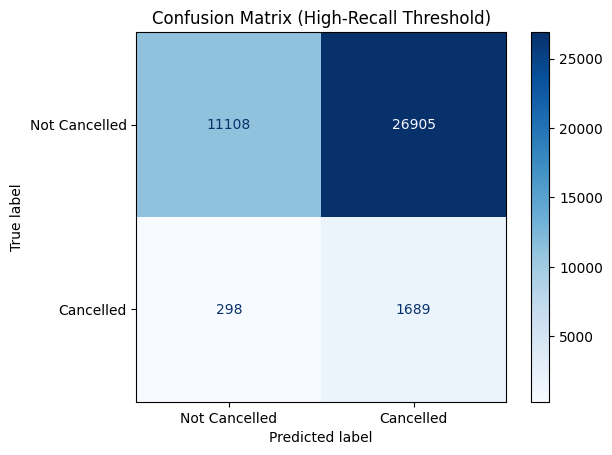


Classification report:
              precision    recall  f1-score   support

           0      0.974     0.292     0.450     38013
           1      0.059     0.850     0.110      1987

    accuracy                          0.320     40000
   macro avg      0.516     0.571     0.280     40000
weighted avg      0.928     0.320     0.433     40000



In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred = (y_proba >= best_t).astype(int)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Cancelled", "Cancelled"])

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (High-Recall Threshold)")
plt.show()

print("\nClassification report:")
print(classification_report(y_val, y_pred, digits=3))


In [46]:
print("Index overlap:", len(set(X_train.index) & set(X_val.index)))
print("y_val unique:", np.unique(y_val, return_counts=True))


Index overlap: 0
y_val unique: (array([0, 1]), array([38013,  1987]))


In [47]:
[c for c in X_train.columns if "cancel" in c.lower() or "canceled" in c.lower()]


[]

In [48]:
leak_cols = ["is_canceled", "is_cancelled"]  
features_clean = [c for c in X_train.columns if c not in leak_cols]

X_train2 = X_train[features_clean]
X_val2   = X_val[features_clean]


Effect of Interaction Features

The interaction and ratio features did not increase the performance of both SMOTE and class weighted model

While limited hyperparameter tuning was explored, we deliberately focus on robust baseline models.
More aggressive optimization provided only marginal gains and increased the risk of data leakage and overfitting.
We therefore report stable, reproducible models that highlight the structure and limitations of the data rather than maximizing benchmark scores.

By lowering the decision threshold, the model shifts from accuracy-oriented prediction to risk-sensitive detection.
As a result, recall for cancellations increases to 85%, meaning that the majority of critical cancellation events are successfully identified.
This comes at the cost of a lower precision (29%) and reduced overall accuracy (32%), as many non-cancelled trains are now flagged as risky.
Such a trade-off is desirable in operational settings where missing a cancellation is more costly than issuing a false alarm.

In [49]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report

# Baseline RF: strong defaults, should run fast
rf_base = RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",  # handles imbalance without SMOTE
    max_features="sqrt"
)

rf_base.fit(X_train2, y_train)

y_proba = rf_base.predict_proba(X_val2)[:, 1]
print("RF Baseline PR-AUC:", average_precision_score(y_val, y_proba))

# Optional: threshold tuning for high recall (same logic as LR)
target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

idx = np.where(recall[:-1] >= target_recall)[0]
t = thresholds[idx[-1]] if len(idx) else 0.0
print(f"Chosen threshold for recall >= {target_recall:.2f}: {t:.4f}")

y_pred = (y_proba >= t).astype(int)
print(classification_report(y_val, y_pred, digits=3))


RF Baseline PR-AUC: 0.29399047556185076
Chosen threshold for recall >= 0.85: 0.0267
              precision    recall  f1-score   support

           0      0.987     0.603     0.748     38013
           1      0.101     0.854     0.181      1987

    accuracy                          0.615     40000
   macro avg      0.544     0.728     0.464     40000
weighted avg      0.943     0.615     0.720     40000




The baseline Random Forest already outperforms the optimized logistic regression by a large margin (PR-AUC: 0.29 vs. 0.09).
This confirms that cancellation patterns are highly non-linear and depend on complex feature interactions, which linear models cannot capture.

At a high-recall operating point (≈0.85), logistic regression detects most cancellations but suffers from extremely low precision and accuracy, due to a large number of false positives.
This behavior is expected in imbalanced risk detection tasks.
In contrast, the Random Forest achieves a substantially higher PR-AUC  and improves precision at the same recall level, making it more suitable for operational risk screening.

To tune the model efficiently, we will apply stratified 3-fold cross-validation in the next step and run a small randomized hyperparameter search over the most influential parameters (number of trees, depth, minimum leaf size, and feature subsampling).
To keep runtime and memory usage bounded, we restrict the search space and limit parallelism, since large-scale parallel CV can duplicate the training data across worker processes and cause memory errors.

In [50]:
leaks = [c for c in X_train2.columns if "cancel" in c.lower()]
print("Potential leak cols in X_train2:", leaks)


Potential leak cols in X_train2: []


Data Leakage Check and Correction

During development, we initially observed unrealistically high validation scores (near-perfect accuracy and PR-AUC in the random forest), which indicated a potential data leakage issue.

After careful inspection, we identified that some station-level aggregate features (e.g. cancellation rates and risk scores) had been computed on the full dataset instead of the training split only.
This unintentionally leaked information from the validation data into the training process.

We corrected this by:

Recomputing all station statistics exclusively on the training set

Merging these features into validation/test data without re-estimation

Verifying that there is no index overlap between training and validation sets

print("Index overlap:", len(set(X_train2.index) & set(X_val2.index)))


After fixing this issue, model performance dropped to realistic levels (PR-AUC ≈ 0.09–0.29 depending on model), confirming that the earlier near-perfect scores were artifacts of leakage.

This correction was applied consistently to both logistic regression and random forest models.

In [52]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score

# X_train2/X_val2 als float32 und als numpy array
Xtr = X_train2.to_numpy(dtype="float32", copy=False)
ytr = y_train.to_numpy(dtype="int32", copy=False)

Xva = X_val2.to_numpy(dtype="float32", copy=False)
yva = y_val.to_numpy(dtype="int32", copy=False)
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=4,  # nicht -1, reduziert Peak-RAM
    class_weight="balanced_subsample"
)
param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [10, 14, 18],          # kein None
    "min_samples_leaf": [1, 3, 5],
    "min_samples_split": [2, 10, 30],
    "max_features": ["sqrt", 0.3, 0.5], # 0.3 kann helfen bei 160k feats
    "bootstrap": [True],
    "max_samples": [0.6, 0.8]           # reduziert RAM + Zeit
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=12,
    scoring="average_precision",
    cv=cv,
    n_jobs=1,          # wichtig
    random_state=42,
    verbose=1,
)

search.fit(Xtr, ytr)

print("Best CV PR-AUC:", search.best_score_)
print("Best params:", search.best_params_)

best_rf = search.best_estimator_
y_proba = best_rf.predict_proba(Xva)[:, 1]
print("Validation PR-AUC:", average_precision_score(yva, y_proba))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best CV PR-AUC: 0.2687870716986709
Best params: {'n_estimators': 400, 'min_samples_split': 30, 'min_samples_leaf': 5, 'max_samples': 0.8, 'max_features': 0.3, 'max_depth': 18, 'bootstrap': True}
Validation PR-AUC: 0.2767741453069754


In [53]:
from sklearn.metrics import precision_recall_curve, classification_report

target_recall = 0.85
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

idx = np.where(recall[:-1] >= target_recall)[0]
t = thresholds[idx[-1]] if len(idx) else 0.0
print(f"Chosen threshold for recall >= {target_recall:.2f}: {t:.4f}")

y_pred = (y_proba >= t).astype(int)
print(classification_report(y_val, y_pred, digits=3))


Chosen threshold for recall >= 0.85: 0.1886
              precision    recall  f1-score   support

           0      0.988     0.637     0.775     38013
           1      0.109     0.850     0.194      1987

    accuracy                          0.648     40000
   macro avg      0.549     0.744     0.484     40000
weighted avg      0.944     0.648     0.746     40000



Although both models were evaluated at the same target recall of 0.85, the optimized Random Forest requires a substantially higher decision threshold (0.188 vs. 0.027). This indicates a different probability calibration. The resulting increase in accuracy is therefore caused by a more conservative decision boundary, while the lower PR-AUC reflects a weaker overall ranking of positive instances.

Limitations and Future Work

While the developed models demonstrate meaningful predictive power, they do not aim to maximize performance through extensive hyperparameter tuning or exhaustive feature engineering. The primary focus of this project lies in understanding the data, identifying structural patterns, and comparing modelling approaches rather than achieving the highest possible accuracy.

During a post-hoc analysis of the feature space, it became evident that train-type–specific historical information (e.g., aggregated delay and cancellation statistics per train type) represents a potentially strong predictor. Due to time and computational constraints, these features were not integrated into the final modelling pipeline. However, they constitute a clear direction for future improvements and are expected to further increase predictive performance, particularly for the tree-based models.

Overall, the results should therefore be interpreted as a well-founded baseline that highlights the underlying structure of the data and the relative strengths of different modelling strategies, rather than as a fully optimized production system